# rgb

In [ ]:
#| default_exp repr_rgb

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test, test_eq, is_close

In [ ]:
# |export
# |hide
from PIL import Image
import torch

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.

# I want to be able to call both `tensor.rgb` and `tensor.rgb(stats)`. For the
# first case, the class defines `_repr_png_` to send the image to Jupyter. For
# the later case, it defines __call__, which accps the argument.

class ImageProxy(Image.Image):
    """Flexible `PIL.Image.Image` wrapper"""
    @torch.no_grad()
    def __init__(self, t:torch.Tensor):
        super().__init__()
        self.t = t.detach().permute(1, 2, 0)
        
        # Mode and size - to be used by super().__repr__()
        self.mode = "RGB"
        self._size = tuple(t.shape[1:])

    @torch.no_grad()
    def __call__(self, denorm=None):            
        means = torch.tensor(denorm["mean"] if denorm else (0., 0., 0.,), device=self.t.device)
        stds = torch.tensor(denorm["std"] if denorm else (1., 1., 1.,), device=self.t.device)
        return Image.fromarray((self.t*stds+means).mul(255).byte().cpu().numpy())

    @torch.no_grad()
    def _repr_png_(self):
        "Jupyter PNG representation"
        return Image.fromarray(self.t.mul(255).byte().cpu().numpy())._repr_png_()


In [ ]:
# |export
def rgb(t: torch.Tensor, denorm=None):
    return ImageProxy(t)(denorm)

In [ ]:
in_stats = { "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225) }

image = torch.load("mysteryman.pt")

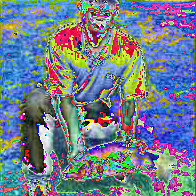

In [ ]:
rgb(image)

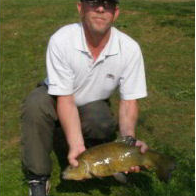

In [ ]:
rgb(image, denorm=in_stats)

before allocation: torch.cuda.memory_allocated()=0
after allocation: torch.cuda.memory_allocated()=393216


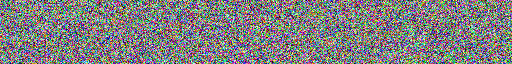

after rgb: torch.cuda.memory_allocated()=393216
after cleanup: torch.cuda.memory_allocated()=0


In [ ]:
if torch.cuda.is_available():
    cudamem = torch.cuda.memory_allocated()
    print(f"before allocation: {torch.cuda.memory_allocated()=}")
    numbers = torch.randn((3, 64, 512), device="cuda")
    torch.cuda.synchronize()
    print(f"after allocation: {torch.cuda.memory_allocated()=}")
    display(rgb(numbers))
    print(f"after rgb: {torch.cuda.memory_allocated()=}")
   
    del numbers
    # torch.cuda.memory.empty_cache()

    print(f"after cleanup: {torch.cuda.memory_allocated()=}")
    test_eq(cudamem >= torch.cuda.memory_allocated(), True)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()